In [6]:
!"/opt/homebrew/Cellar/jupyterlab/4.4.2_1/libexec/bin/python" -m pip install pandas matplotlib seaborn


The system cannot find the path specified.



Average Trips Comparison by Line:
Line  Current_Trips  Optimized_Trips
  M2       7.333333        28.170940
  M4       7.100000        15.525000
  M3       7.239130        15.173913
  M5       7.125000        14.375000
  M8       6.915254        13.203390
  M9       6.454545        11.727273
  M7       7.157895        11.210526

Data Availability Statistics:
Total days in 2024: 366
Available days: 7
Unavailable days: 359
Data availability ratio: 1.91%


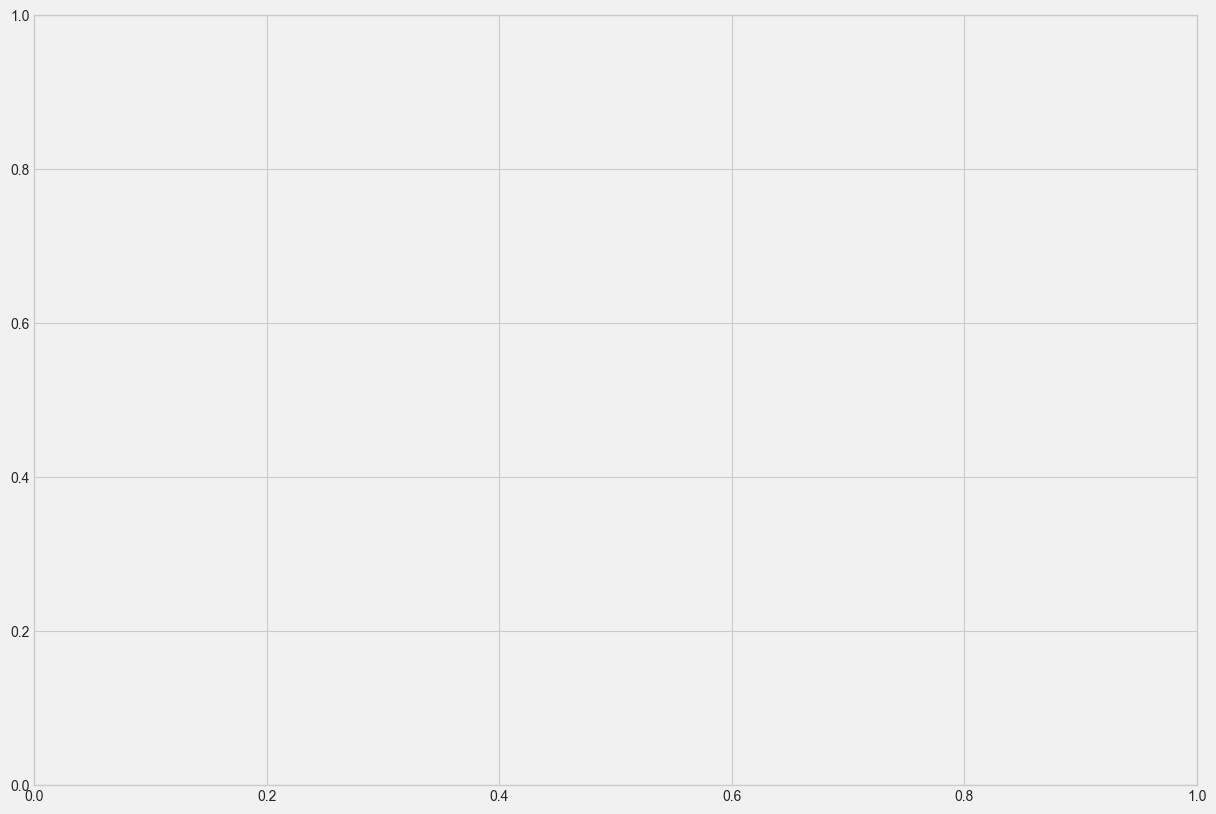

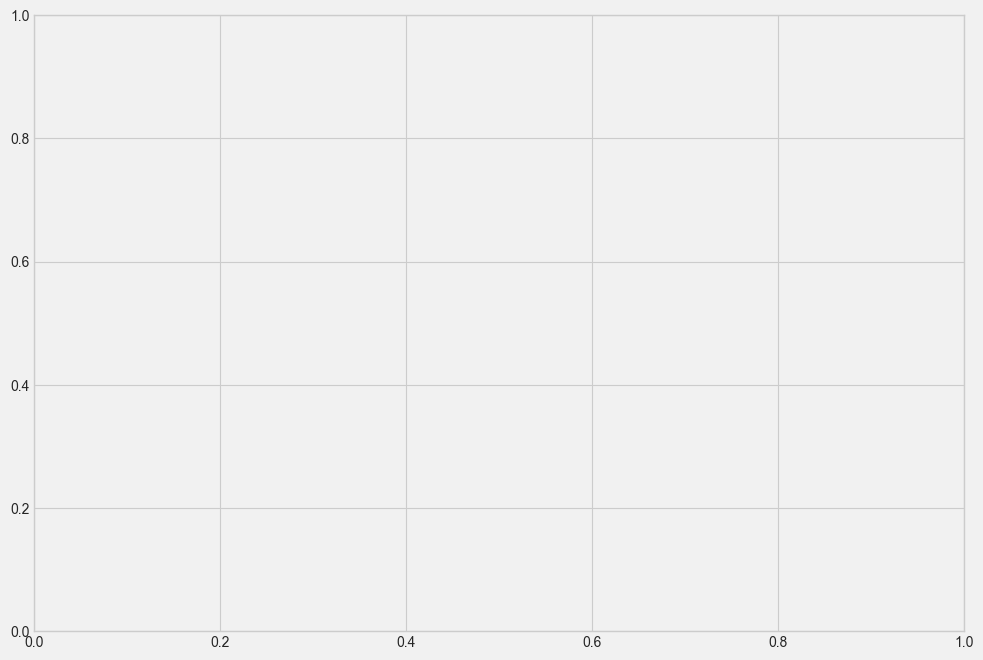

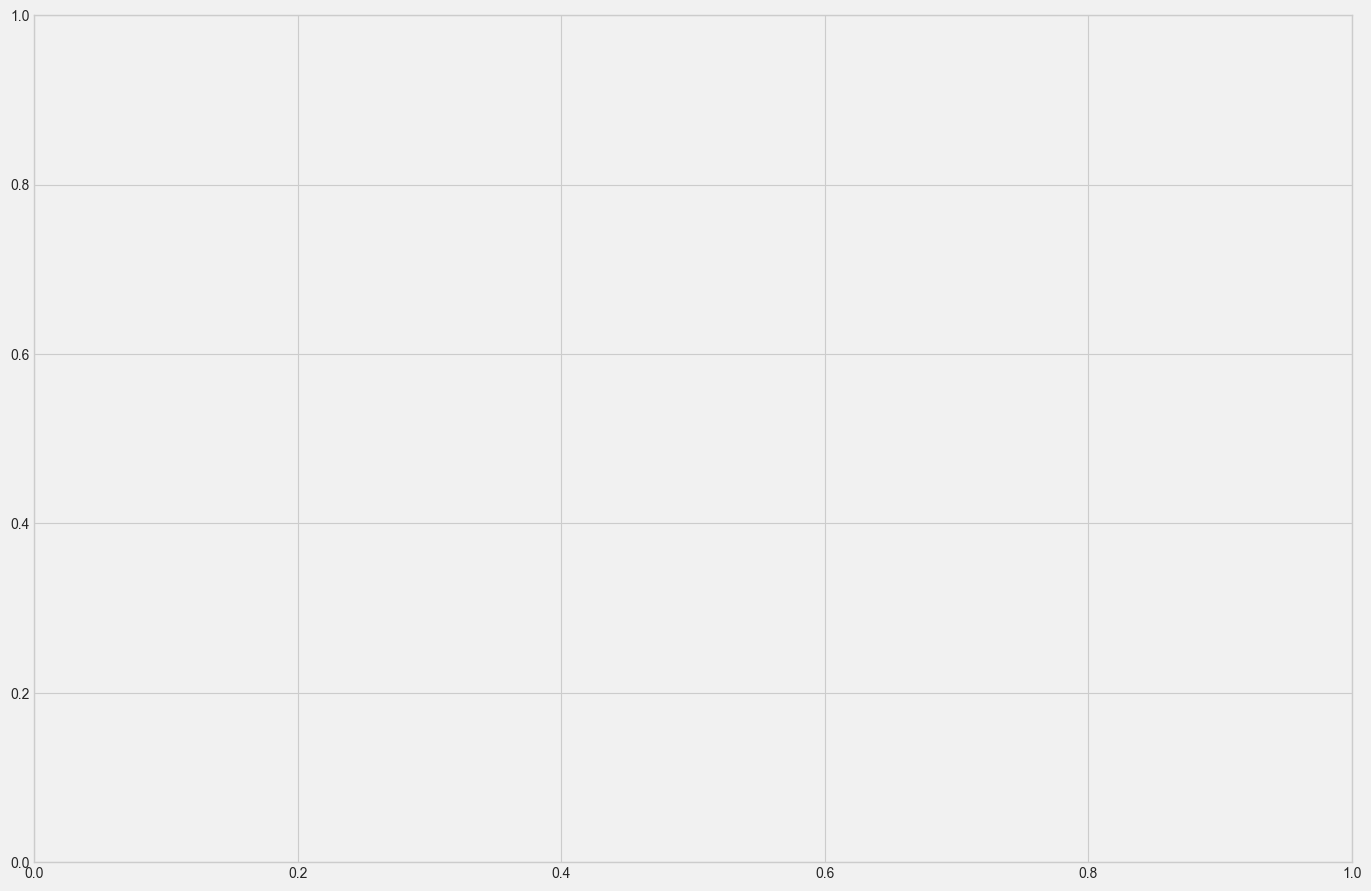

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Set style
plt.style.use('seaborn-v0_8-whitegrid') 
sns.set_palette("husl")

def set_plot_background():
    plt.gca().set_facecolor('#f1f1f1')
    plt.gcf().set_facecolor('#f1f1f1')

opt_df = pd.read_csv('../Data/output/results/optimization_results.csv')

daily_df = pd.read_csv('../Data/output/final/finalseptemberdailydata.csv')

schedule_df = pd.read_csv('../Data/output/final/metro_schedule.csv')

opt_df['Date'] = pd.to_datetime(opt_df['Date'])
daily_df['transition_date'] = pd.to_datetime(daily_df['transition_date'])

daily_df = daily_df.rename(columns={
    'station_poi_desc_cd': 'Station',
    'line_name': 'Line',
    'transition_date': 'Date',
    'number_of_passenger': 'Passenger_Demand'
})

schedule_df_weekday = schedule_df[schedule_df['Day_Type'] == 'Weekday']


transfer_stations = [
    'Yenibosna', 'Yenikapı', 'İkitelli Sanayi', 'Levent', 'Şişli-Mecidiyeköy',
    'Kağıthane', 'Kozyatağı', 'Dudullu', 'Gayrettepe', 'Mahmutbey',
    'Bostancı', 'Kirazlı'
]

daily_station_demand = daily_df.groupby(['Date', 'Station', 'Line'])['Passenger_Demand'].sum().reset_index()
avg_daily_station_demand = daily_station_demand.groupby(['Station', 'Line'])['Passenger_Demand'].mean().reset_index()

# 1. Average Daily Passenger Demand for Transfer Stations (Disaggregated by Line)
transfer_demand_avg_daily_by_line = avg_daily_station_demand[avg_daily_station_demand['Station'].isin(transfer_stations)].copy()

transfer_demand_avg_daily_by_line['Station_Line'] = transfer_demand_avg_daily_by_line['Station'] + ' - ' + transfer_demand_avg_daily_by_line['Line']

transfer_demand_avg_daily_by_line = transfer_demand_avg_daily_by_line.sort_values('Passenger_Demand', ascending=False)

transfer_station_avg_daily_by_line_heatmap_df = transfer_demand_avg_daily_by_line.set_index('Station_Line')['Passenger_Demand'].to_frame()

plt.figure(figsize=(20, 10)) 
set_plot_background()
sns.heatmap(transfer_station_avg_daily_by_line_heatmap_df, 
            cmap='YlOrRd',
            annot=True,
            fmt='.0f',
            annot_kws={'size': 16},  
            cbar_kws={'label': 'Average Daily Passenger Demand'},  
            square=False)
plt.title('Average Daily Passenger Demand at Transfer Stations (By Line)', fontsize=22, fontweight='bold', pad=20) # Further increase title size
plt.xlabel('')
plt.ylabel('Station - Line', fontsize=18)
plt.yticks(fontsize=14)  
plt.gcf().axes[-1].set_ylabel('Average Daily Passenger Demand', fontsize=16)
plt.tight_layout()
plt.savefig('../Data/output/visuals/transfer_stations_average_daily_demand_by_line_heatmap.png', dpi=300, bbox_inches='tight', facecolor='#f1f1f1') # Update filename
plt.close()

# Create a bar plot for average daily passenger demand by line
plt.figure(figsize=(15, 8))
set_plot_background()
sns.barplot(x='Station_Line', y='Passenger_Demand', data=transfer_demand_avg_daily_by_line, palette='viridis')
plt.title('Average Daily Passenger Demand for Transfer Stations (By Line)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Station - Line', fontsize=14)
plt.ylabel('Average Daily Passenger Demand', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.grid(True, alpha=1, linestyle='--', linewidth=1.1, axis='y') 
plt.tight_layout()
plt.savefig('../Data/output/visuals/transfer_stations_average_daily_demand_by_line_bar.png', dpi=300, bbox_inches='tight', facecolor='#f1f1f1')
plt.close()

# 2. Average Daily Passenger Demand for Each Metro Line
daily_line_demand = daily_df.groupby(['Date', 'Line'])['Passenger_Demand'].sum().reset_index()
avg_daily_line_demand = daily_line_demand.groupby('Line')['Passenger_Demand'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8)) 
set_plot_background()
avg_daily_line_demand.plot(kind='bar')
plt.title('Average Daily Passenger Demand by Metro Line', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Metro Line', fontsize=12)
plt.ylabel('Average Daily Passenger Demand', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/output/visuals/line_demand.png', facecolor='#f1f1f1')
plt.close()

# 3. Average Hourly Additional Trips by Line (using opt_df)
hourly_trips = opt_df.groupby(['Line', 'Hour'])['Additional_Trips'].mean().unstack()

plt.figure(figsize=(15, 10))
set_plot_background()
hourly_trips.plot(kind='bar', stacked=True)
plt.title('Average Hourly Additional Trips by Line (from Optimization)')
plt.xlabel('Metro Line')
plt.ylabel('Average Additional Trips')
plt.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/output/visuals/hourly_trips_by_line_optimization.png', facecolor='#f1f1f1')
plt.close()

# 4. Top 10 Stations by Average Passenger Demand (using daily_df)
top_stations = avg_daily_station_demand.head(10)

plt.figure(figsize=(12, 8))
set_plot_background()
top_stations.plot(kind='bar')
plt.title('Top 10 Stations by Average Daily Passenger Demand')
plt.xlabel('Station')
plt.ylabel('Average Daily Passenger Demand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/output/visuals/top_stations_demand.png', facecolor='#f1f1f1')
plt.close()

# 5. Average Daily Total Additional Trips by Line (using opt_df)
daily_additional_trips = opt_df.groupby(['Date', 'Line'])['Additional_Trips'].sum().reset_index()
avg_daily_total_additional_trips_per_line = daily_additional_trips.groupby('Line')['Additional_Trips'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
set_plot_background()
avg_daily_total_additional_trips_per_line.plot(kind='bar')
plt.title('Average Daily Total Additional Trips by Line (from Optimization)')
plt.xlabel('Metro Line')
plt.ylabel('Average Daily Total Additional Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/output/visuals/average_daily_total_additional_trips_by_line_optimization.png', facecolor='#f1f1f1')
plt.close()

# 6. Scheduled Number of Trips per Hour by Line (Peak Hours)
peak_hours = [7, 8, 9, 16, 17, 18]
schedule_df_peak_hours = schedule_df_weekday[schedule_df_weekday['transition_hour'].isin(peak_hours)]
weekly_scheduled_trips_peak_hours = schedule_df_peak_hours.groupby(['Line', 'transition_hour'])['Number_of_Trips'].sum().unstack()

plt.figure(figsize=(17, 11))
set_plot_background()
weekly_scheduled_trips_peak_hours.plot(kind='bar', stacked=True)
plt.title('Scheduled Number of Trips per Hour by Line (Peak Hours)')
plt.xlabel('Metro Line')
plt.ylabel('Number of Trips')
plt.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../Data/output/visuals/scheduled_trips_per_hour_peak_hours.png', facecolor='#f1f1f1')
plt.close()


# 8. Average Current vs. Optimized Trips by Line
line_comparison = opt_df.groupby('Line').agg({
    'Current_Trips': 'mean',
    'Additional_Trips': 'mean'
}).reset_index()

line_comparison['Optimized_Trips'] = line_comparison['Current_Trips'] + line_comparison['Additional_Trips']
line_comparison = line_comparison.sort_values('Optimized_Trips', ascending=False)

plt.figure(figsize=(12, 8))
set_plot_background()
x = range(len(line_comparison['Line']))
width = 0.35

plt.bar([i - width/2 for i in x], line_comparison['Current_Trips'], width, label='Current Trips', color='skyblue')
plt.bar([i + width/2 for i in x], line_comparison['Optimized_Trips'], width, label='Optimized Trips', color='lightgreen')

plt.xlabel('Metro Line', fontsize=12)
plt.ylabel('Average Number of Trips', fontsize=12)
plt.title('Average Current vs. Optimized Trips by Line', fontsize=18, fontweight='bold', pad=20)
plt.xticks(x, line_comparison['Line'], rotation=45)
plt.legend(fontsize=10)
plt.grid(True, alpha=1, linestyle='--', linewidth=1.1)
plt.tight_layout()
plt.savefig('../Data/output/visuals/current_vs_optimized_trips_by_line.png', dpi=300, bbox_inches='tight', facecolor='#f1f1f1')
plt.close()

print("\nAverage Trips Comparison by Line:")
print(line_comparison[['Line', 'Current_Trips', 'Optimized_Trips']].to_string(index=False))

# 9. Data Availability Pie Chart
total_days_2024 = 366 
available_days = 7
unavailable_days = total_days_2024 - available_days

plt.figure(figsize=(10, 10))
set_plot_background()

colors = ['#2ecc71', '#e74c3c']  
explode = (0.1, 0)  

plt.pie([available_days, unavailable_days],
        labels=['Available Data\n(7 days)', 'Unavailable Data\n(359 days)'],
        colors=colors,
        explode=explode,
        autopct='%1.1f%%',
        pctdistance=0.85,
        textprops={'fontsize': 14, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'white', 'linewidth': 2})

plt.title('Data Availability for 2024\n(7 days vs. Total 366 days)', 
          fontsize=20, 
          fontweight='bold', 
          pad=20)

plt.legend(loc='upper right', 
          bbox_to_anchor=(1.3, 1),
          fontsize=12)

plt.tight_layout()
plt.savefig('../Data/output/visuals/data_availability_pie.png', 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='#f1f1f1')
plt.close()

print("\nData Availability Statistics:")
print(f"Total days in 2024: {total_days_2024}")
print(f"Available days: {available_days}")
print(f"Unavailable days: {unavailable_days}")
print(f"Data availability ratio: {(available_days/total_days_2024)*100:.2f}%")